# Imports

In [1]:
PROJECT_PATH = '.'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from lib_tds_rg.tds_rg_module import StatisticalTests as stest
from lib_tds_rg.tds_rg_module import TheoreticalDistributionFitter as dist_fitter
from lib_tds_rg.plotting_utils import DistributionPlotter as plotter
from lib_tds_rg.dataset_handling_utils import *
from lib_tds_rg.empirical_experiments_utils import *

mpl.style.use("ggplot")
warnings.filterwarnings("ignore")

# Constants

In [3]:
SEED = 2022

# Handle datasets

<u>Source:</u>

*   Dataset 1 - [Houses price prediction](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
*   Dataset 2 - [Cancer detection](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)
*   Dataset 3 - [Stress detection in sleep](https://www.kaggle.com/laavanya/human-stress-detection-in-and-through-sleep)
*   Dataset 4 - [Salaries in san fransisco ](https://www.kaggle.com/kaggle/sf-salaries)

## Load the datasets

In [4]:
datasets_info = [
    (f"{DS.HOUSES}.csv", preprocess_houses),
    (f"{DS.CANCER}.csv", preprocess_cancer),
    (f"{DS.SLEEPING}.csv", preprocess_sleeping),
    (f"{DS.SALARIES}.csv", preprocess_salaries)
]

dtfs = {}
for dataset in datasets_info:
    full_file_name = dataset[0]
    file_name = full_file_name.split('.')[0]
    file_path = f"{PROJECT_PATH}/datasets/{full_file_name}"
    preprocess_func = dataset[1]
    dtfs[file_name] = read_dataset(file_path, preprocess_func)

# The problem

One of the usages of statistical tests is to help the scientists conclude whether a data is drawn from a specific population or not, and which distributions are identical.<p>
Even though they are widely used, those statistical tests perform badly on several use cases, and it can be seen in the following examples.<p>


- When the samples generated from the same distribution but with **slightly** different parameters, the p-values are basically zero.

                   Results                   
+------------------+------------------------+
| Statistical Test |          Value         |
+==================+========================+
| KS test          | 0.00021851817013518544 |
+------------------+------------------------+
| CVM test         | 3.45736350954029e-05   |
+------------------+------------------------+


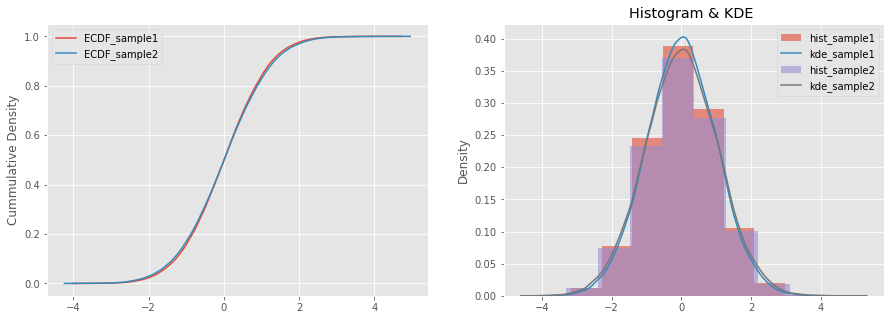

In [5]:
sample_size = 50_000
np.random.seed(SEED)
sample1 = np.random.normal(0, 1, sample_size)
np.random.seed(SEED)
sample2 = np.random.normal(0, 1.05, sample_size)

# Perform statistical test
tests = ['KS test', 'CVM test']
pvals = [stest.ks_2_sample_test(sample1, sample2), 
        stest.cvm_2_sample_test(sample1, sample2)]
tabulate_data(cols=[tests, pvals],
              headers=['Statistical Test', 'Value'],
              title='Results')
# Plot samples
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plotter.plot_ecdfs([sample1, sample2], ['sample1', 'sample2'])
plt.subplot(1, 2, 2)
plotter.plot_histograms_kdes([sample1, sample2], ['sample1', 'sample2'])

- When the data generated relatively similar distributions but not the same generator, p-values also small enough to be considered 0.

                   Results                    
+------------------+-------------------------+
| Statistical Test |          Value          |
+==================+=========================+
| KS test          | 1.1440468848447581e-162 |
+------------------+-------------------------+
| CVM test         | 2.123847342438978e-08   |
+------------------+-------------------------+


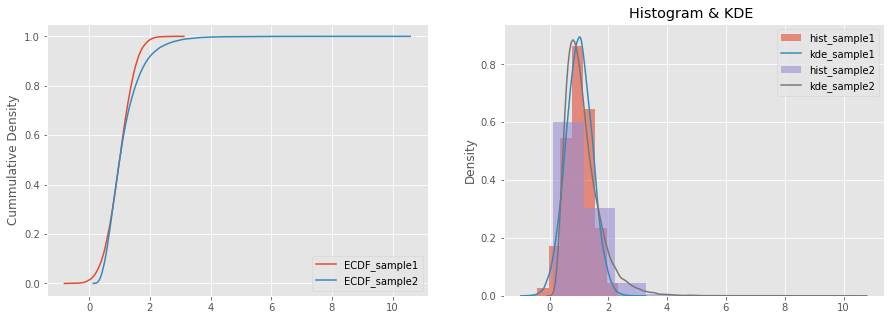

In [6]:
np.random.seed(SEED)
sample_size = 50_000
sample1 = np.random.normal(1, 0.45, sample_size)
np.random.seed(SEED)
sample2 = np.random.lognormal(0, 0.5, sample_size)

# Perform statistical test
tests = ['KS test', 'CVM test']
pvals = [stest.ks_2_sample_test(sample1, sample2), 
        stest.cvm_2_sample_test(sample1, sample2)]
tabulate_data(cols=[tests, pvals],
              headers=['Statistical Test', 'Value'],
              title='Results')
# Plot samples
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plotter.plot_ecdfs([sample1, sample2], ['sample1', 'sample2'])
plt.subplot(1, 2, 2)
plotter.plot_histograms_kdes([sample1, sample2], ['sample1', 'sample2'])

- There are stability issues depending on the different statistical test, sample size, random seed, etc. <p>
Several runs with the same generator can **yield** very different p-values,<p> sometimes even lower than the minimum level needed to accept the null hypothesis.

           KS - Result Statistics           
+-------------------+----------------------+
| Statistics Metric |         Value        |
+===================+======================+
| ks_pvalues_mean   | 0.4646631222769703   |
+-------------------+----------------------+
| ks_pvalues_std    | 0.27044329585217025  |
+-------------------+----------------------+
| ks_pvalues_min    | 0.027358993752703786 |
+-------------------+----------------------+
| ks_pvalues_max    | 0.9126515358646757   |
+-------------------+----------------------+
          CVM - Result Statistics           
+-------------------+----------------------+
| Statistics Metric |         Value        |
+===================+======================+
| cvm_pvalues_mean  | 0.4695687552927909   |
+-------------------+----------------------+
| cvm_pvalues_std   | 0.299323116449492    |
+-------------------+----------------------+
| cvm_pvalues_min   | 0.041374165326566015 |
+-------------------+----------------------+
| cvm_pval

Text(0.5, 1.0, 'CVM P-values')

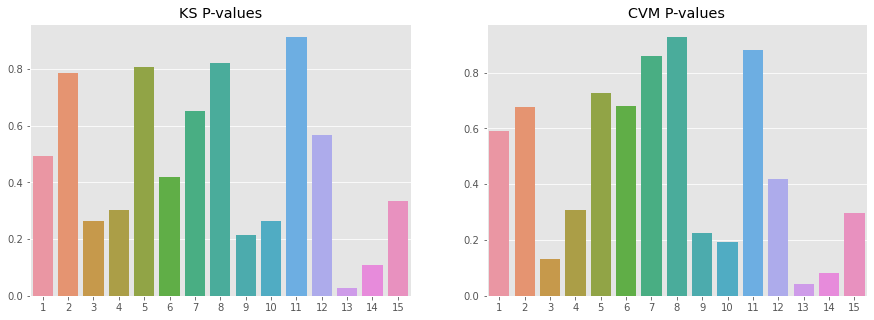

In [7]:
num_of_samples = 15
sample_size = 40_000
np.random.seed(SEED)
ks_pvalues = list()
cvm_pvalues = list()
for _ in range(num_of_samples):
    sample1 = np.random.normal(0, 1, sample_size)
    sample2 = np.random.normal(0, 1, sample_size)
    ks_pvalue = stest.ks_2_sample_test(sample1, sample2) 
    cvm_pvalue = stest.cvm_2_sample_test(sample1, sample2)
    ks_pvalues.append(ks_pvalue)
    cvm_pvalues.append(cvm_pvalue)

titles = ['KS - Result Statistics', 'CVM - Result Statistics']
values = [[np.mean(ks_pvalues), np.std(ks_pvalues), np.min(ks_pvalues), np.max(ks_pvalues)],
          [np.mean(cvm_pvalues), np.std(cvm_pvalues), np.min(cvm_pvalues), np.max(cvm_pvalues)]]
stats = [["ks_pvalues_mean", "ks_pvalues_std", "ks_pvalues_min", "ks_pvalues_max"], 
         ["cvm_pvalues_mean", "cvm_pvalues_std", "cvm_pvalues_min", "cvm_pvalues_max"]]

for i,v in enumerate(values):
    tabulate_data(cols=[stats[i], v], headers=['Statistics Metric', 'Value'], title=titles[i])

xs = list(range(1, num_of_samples + 1))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(xs, ks_pvalues)
plt.title('KS P-values')
plt.subplot(1, 2, 2)
sns.barplot(xs, cvm_pvalues)
plt.title('CVM P-values')

# Our solution


The basic idea of the method is to use KDEs of both distributions, to compute the normalized Root Mean Squared Error (RMSE) between the KDEs.
<br>
Our method supports scaling the data to [0,1], when the similarity needed between 2 distributions with different value ranges, e.g. height vs weight.

<u>Algorithm steps:</u>
```
    1. Scale the samples so they are on the same domain (optional)
    2. Calculate the KDE for each sample
    3. Evaluate the values of the KDEs on each of the data sample points
    4. Compute a root mean squared error between the KDEs values
    5. Normalize the result to range [0,1]
```

# Experiments

 ## Top K theoretical distributions view

 This comes to serve as a view of what are the top K theoretical
 distribution the data could be sampled from.<br>
 The theoretical CDF built by fitting the parameters using maximum likelihood estimation (MLE).<br>
 The scoring metric based on combined P-Values of Kolmogorov-Smirnov and Cramér-von Mises statistical tests using the Fisher method.

 <br>
 <u>Note:</u> This is not the main part of the project, but comes as a complementary view.

In [8]:
k = 3

### Dataset 1 - [Houses price prediction](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [9]:
dtfs[DS.HOUSES].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### SalePrice - The property's sale price in dollars

      Top 3 theoretical distributions      
+--------------------+--------------------+
|  Distribution Name |       P-Value      |
+====================+====================+
| laplace_asymmetric | 0.6406016671032433 |
+--------------------+--------------------+
| johnsonsu          | 0.5928878726574854 |
+--------------------+--------------------+
| exponnorm          | 0.5032844552861733 |
+--------------------+--------------------+


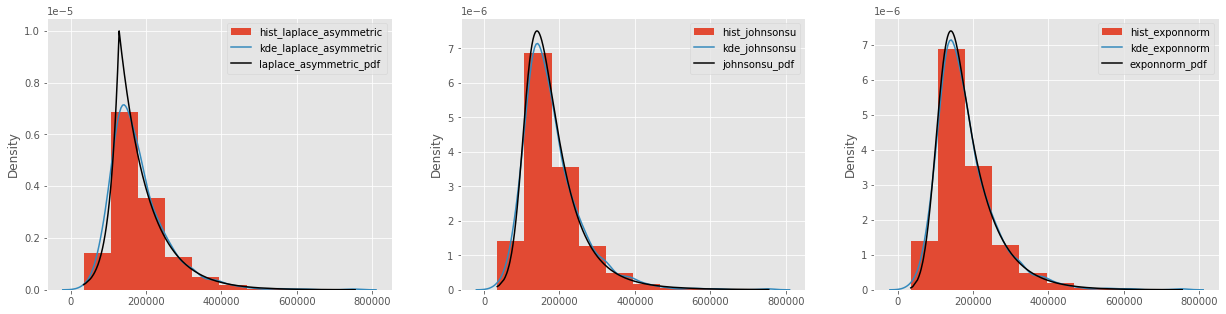

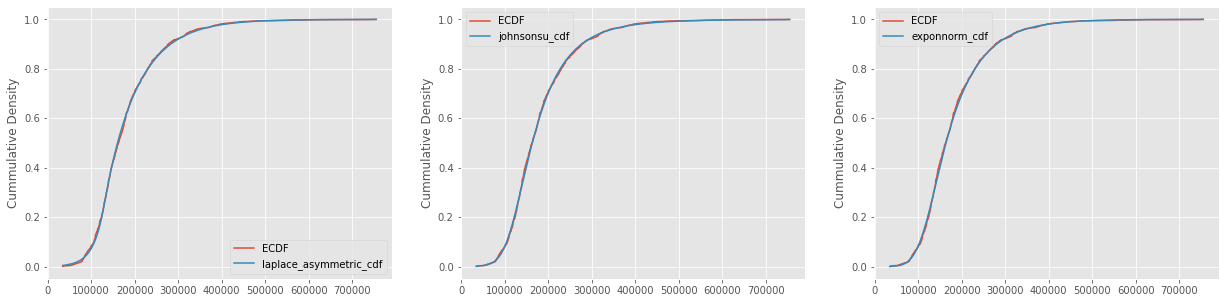

In [10]:
data = dtfs[DS.HOUSES].SalePrice
top_k_theoretical_dists = dist_fitter.top_k_theoretical_distributions(data, k)
plotter.plot_top_k(data, top_k_theoretical_dists)

### Dataset 2 - [Cancer detection](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

In [11]:
dtfs[DS.CANCER].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Radius - Mean of distances from center to points on the perimeter

      Top 3 theoretical distributions       
+--------------------+---------------------+
|  Distribution Name |       P-Value       |
+====================+=====================+
| exponnorm          | 0.5477732341352288  |
+--------------------+---------------------+
| laplace_asymmetric | 0.45171798968859034 |
+--------------------+---------------------+
| burr               | 0.3890413472989746  |
+--------------------+---------------------+


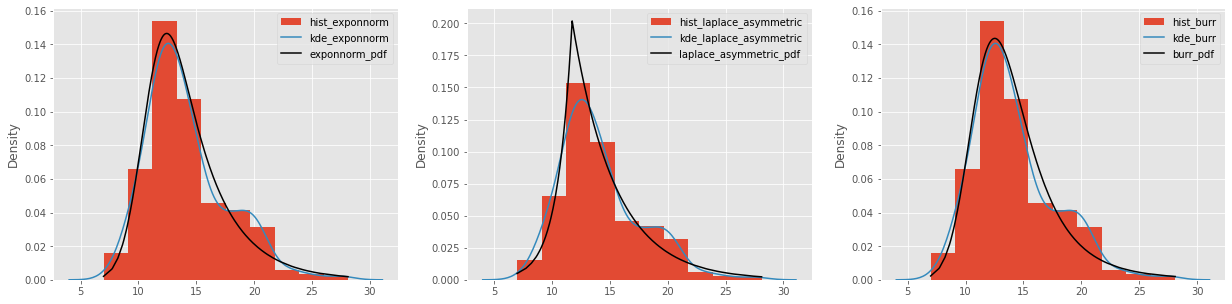

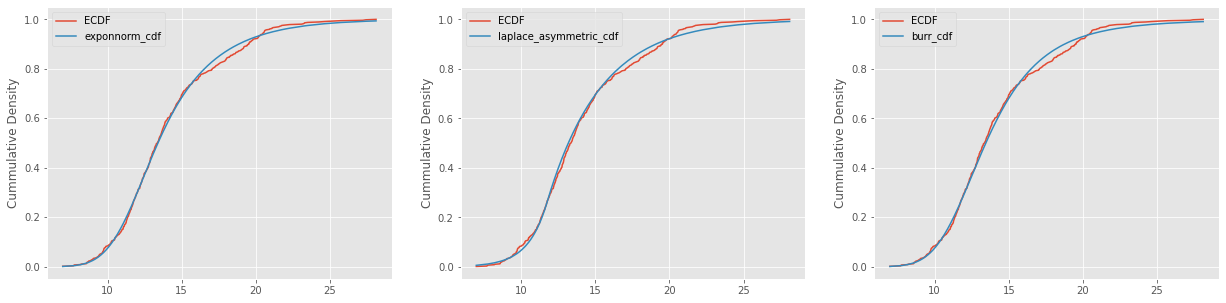

In [12]:
data = dtfs[DS.CANCER].radius_mean
top_k_theoretical_dists = dist_fitter.top_k_theoretical_distributions(data, k)
plotter.plot_top_k(data, top_k_theoretical_dists)

### Dataset 3 - [Stress detection in sleep](https://www.kaggle.com/laavanya/human-stress-detection-in-and-through-sleep)

In [13]:
dtfs[DS.SLEEPING].describe()

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
count,630.000000,630.000000,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,71.600000,21.800000,92.80000,11.700000,90.900000,88.500000,3.700000,64.500000,2.000000
std,19.372833,3.966111,3.52969,4.299629,3.902483,11.893747,3.054572,9.915277,1.415337
min,45.000000,16.000000,85.00000,4.000000,82.000000,60.000000,0.000000,50.000000,0.000000
25%,52.500000,18.500000,90.50000,8.500000,88.500000,81.250000,0.500000,56.250000,1.000000
50%,70.000000,21.000000,93.00000,11.000000,91.000000,90.000000,3.500000,62.500000,2.000000
75%,91.250000,25.000000,95.50000,15.750000,94.250000,98.750000,6.500000,72.500000,3.000000
max,100.000000,30.000000,99.00000,19.000000,97.000000,105.000000,9.000000,85.000000,4.000000


#### t - Body temperature

     Top 3 theoretical distributions      
+-------------------+--------------------+
| Distribution Name |       P-Value      |
+===================+====================+
| gengamma          | 0.7891491117393825 |
+-------------------+--------------------+
| genextreme        | 0.6358750453638553 |
+-------------------+--------------------+
| johnsonsu         | 0.6124180266928607 |
+-------------------+--------------------+


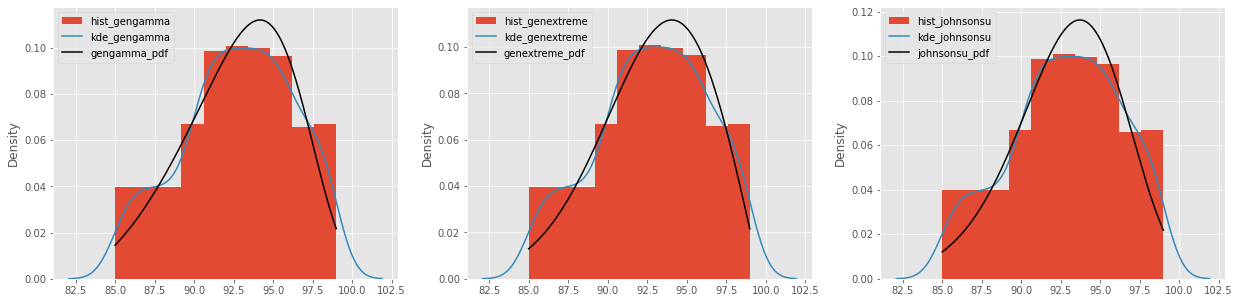

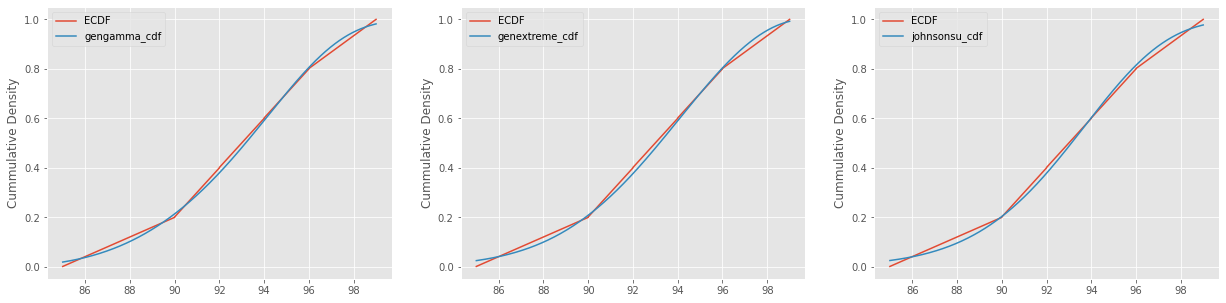

In [14]:
data = dtfs[DS.SLEEPING].t
top_k_theoretical_dists = dist_fitter.top_k_theoretical_distributions(data, k)
plotter.plot_top_k(data, top_k_theoretical_dists)

### Dataset 4 - [Salaries in san fransisco ](https://www.kaggle.com/kaggle/sf-salaries)

In [15]:
dtfs[DS.SALARIES].describe()

,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
count,148650.000000,148650.000000,148650.000000,148650.000000,148650.000000,148650.000000,148650.000000
mean,66055.506718,5066.037953,3630.823701,18903.084762,74752.368371,93655.453133,2004.329768
std,42885.919334,11454.389048,8006.527409,17183.943535,50533.526462,62841.639818,128.135055
min,-166.010000,-0.010000,-7058.590000,-13.800000,-618.130000,-618.130000,0.000000
25%,32798.550000,0.000000,0.000000,0.000000,36138.505000,44054.507500,2012.000000
50%,64862.310000,0.000000,800.000000,23215.625000,71422.120000,92399.120000,2013.000000
75%,94609.715000,4658.175000,4216.727500,33468.980000,105834.127500,132876.450000,2014.000000
max,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,567595.430000,2014.000000


#### BasePay - The base pay of the salary

       Top 3 theoretical distributions       
+-------------------+-----------------------+
| Distribution Name |        P-Value        |
+===================+=======================+
| t                 | 4.742975128207092e-09 |
+-------------------+-----------------------+
| norm              | 4.72893056822393e-09  |
+-------------------+-----------------------+
| rdist             | 4.645035656828739e-09 |
+-------------------+-----------------------+


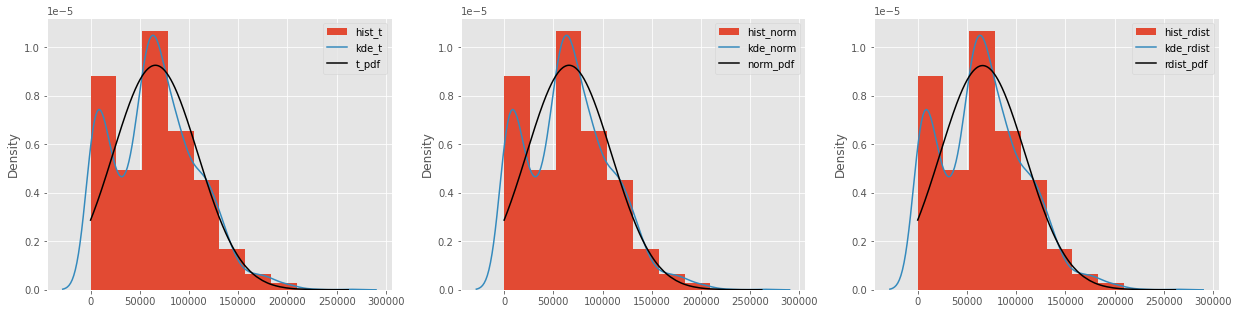

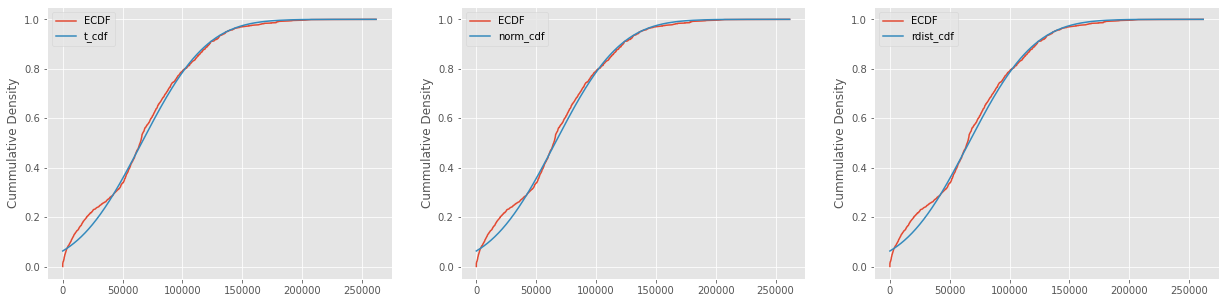

In [16]:
data = dtfs[DS.SALARIES].BasePay.sample(2000)
top_k_theoretical_dists = dist_fitter.top_k_theoretical_distributions(data, k)
plotter.plot_top_k(data, top_k_theoretical_dists)

## Empirical distributions similarity

This part demonstrates our method to compute the similarity between 2 empirical distributions, as described in *'Our solution'* section above.

### Set experiments random seed
Note that there are additional seeds done some of the experiments.<br>
This is done in order to isolate the change of the experiment, so the test results won't be affected by the random state.

In [17]:
np.random.seed(SEED)

### Synthetic data experiments

This section of the experiments shows how synthetic data samples compared with our method vs Kolmogorov-Smirnov and Cramér-von Mises statistical tests.

In [18]:
sample_size = 1000

#### Experiment 1 - Normal distribution similarity

This experiment shows the comparison of 2 samples from the exact same generator(Normal distribution) with the same parameters. 

         Comparison Scores          
+-------------+--------------------+
|    Metric   |        Value       |
+=============+====================+
| RG score    | 96.0918 [%]        |
+-------------+--------------------+
| KS P-Value  | 0.7946637387576738 |
+-------------+--------------------+
| CVM P-Value | 0.8844050952291195 |
+-------------+--------------------+


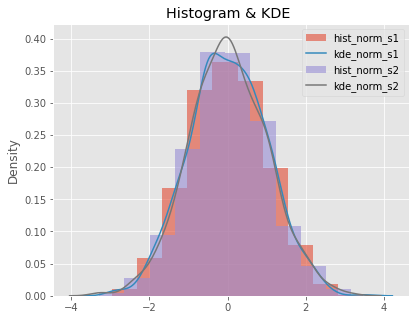

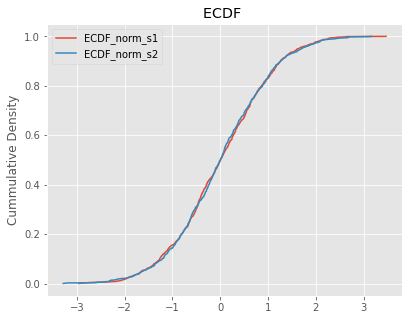

In [19]:
dist_sample1 = np.random.normal(0, 1, sample_size)
dist_sample2 = np.random.normal(0, 1, sample_size)
show_2_sample_comparisons(dist_sample1, dist_sample2, samples_labels=['norm_s1','norm_s2'], show_ecdfs=True)

#### Experiment 2 - Normal distribution similarity with data scaling

This experiment shows the comparison of 2 samples from the same distribution function, but different parameters, i.e. different values domain.

           Comparison Scores           
+-------------+-----------------------+
|    Metric   |         Value         |
+=============+=======================+
| RG score    | 40.5981 [%]           |
+-------------+-----------------------+
| KS P-Value  | 0.0                   |
+-------------+-----------------------+
| CVM P-Value | 4.037403666945494e-08 |
+-------------+-----------------------+
  Comparison Scores with Scaled data   
+-------------+-----------------------+
|    Metric   |         Value         |
+=============+=======================+
| RG score    | 77.7008 [%]           |
+-------------+-----------------------+
| KS P-Value  | 0.0                   |
+-------------+-----------------------+
| CVM P-Value | 4.037403666945494e-08 |
+-------------+-----------------------+


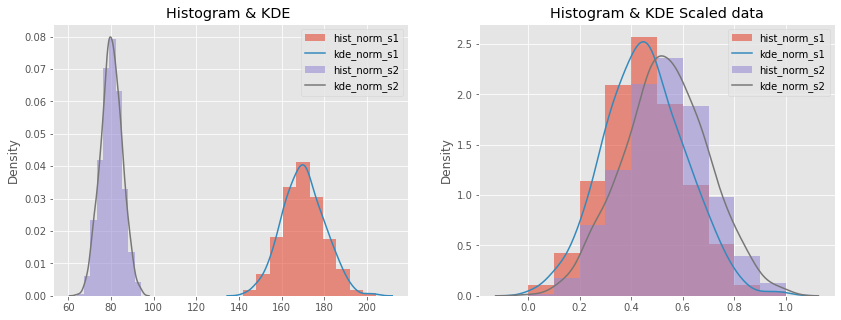

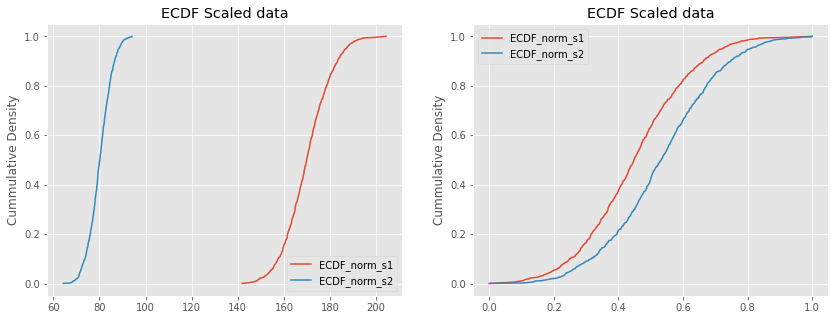

In [20]:
dist_sample1 = np.random.normal(170, 10, sample_size)  # e.g. heights in CM
dist_sample2 = np.random.normal(80, 5, sample_size)  # e.g. weights in KG
show_2_sample_comparisons(dist_sample1, dist_sample2, samples_labels=['norm_s1','norm_s2'], scale_data=True, show_ecdfs=True)

#### Experiment 3 - Chisquare distribution similarity

This experiment shows the comparison of 2 samples from the same distribution function(chisquare distribution), but different parameters with a small change.

            Comparison Scores            
+-------------+-------------------------+
|    Metric   |          Value          |
+=============+=========================+
| RG score    | 52.7011 [%]             |
+-------------+-------------------------+
| KS P-Value  | 1.8765102701407473e-159 |
+-------------+-------------------------+
| CVM P-Value | 1.4603128373202878e-08  |
+-------------+-------------------------+


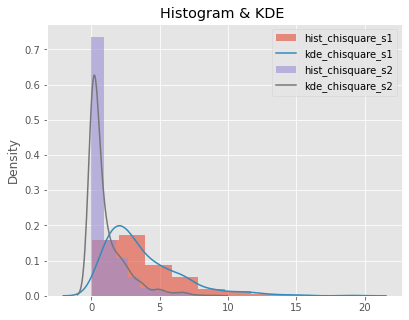

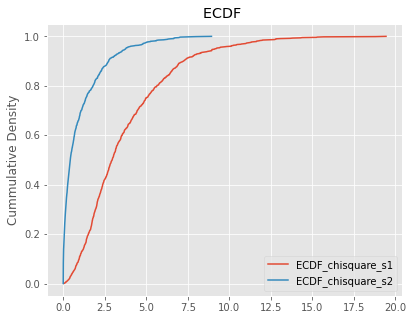

In [21]:
np.random.seed(SEED)
dist_sample1 = np.random.chisquare(3.7, sample_size)
np.random.seed(SEED)
dist_sample2 = np.random.chisquare(1, sample_size)
show_2_sample_comparisons(dist_sample1, dist_sample2, samples_labels=['chisquare_s1','chisquare_s2'], show_ecdfs=True)

#### Experiment 4 - Gamma distribution similarity

This experiment shows the comparison of 2 samples from the exact same generator(Gamma distribution) from right skewed distribution with the same parameters.

          Comparison Scores          
+-------------+---------------------+
|    Metric   |        Value        |
+=============+=====================+
| RG score    | 95.4234 [%]         |
+-------------+---------------------+
| KS P-Value  | 0.43260886958153144 |
+-------------+---------------------+
| CVM P-Value | 0.464980229761107   |
+-------------+---------------------+


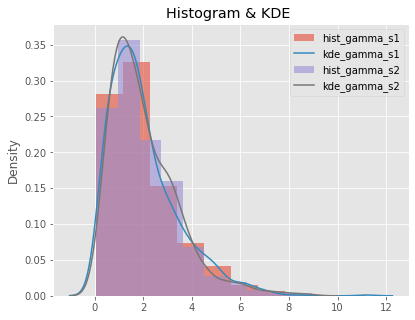

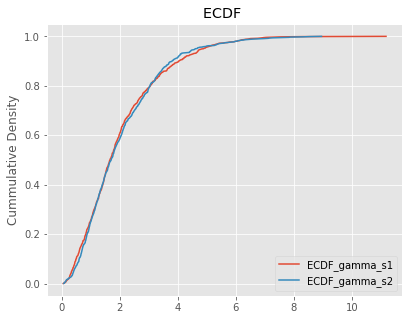

In [22]:
dist_sample1 = np.random.gamma(2, 1, sample_size)
dist_sample2 = np.random.gamma(2, 1, sample_size)
show_2_sample_comparisons(dist_sample1, dist_sample2, samples_labels=['gamma_s1','gamma_s2'], show_ecdfs=True)

#### Experiment 5 - Geometric vs Beta distributions similarity

This experiment shows the comparison of 2 samples from different generators(Geometric and Beta distribution).

          Comparison Scores           
+-------------+----------------------+
|    Metric   |         Value        |
+=============+======================+
| RG score    | 24.4889 [%]          |
+-------------+----------------------+
| KS P-Value  | 0.0                  |
+-------------+----------------------+
| CVM P-Value | 6.55374933211661e-08 |
+-------------+----------------------+


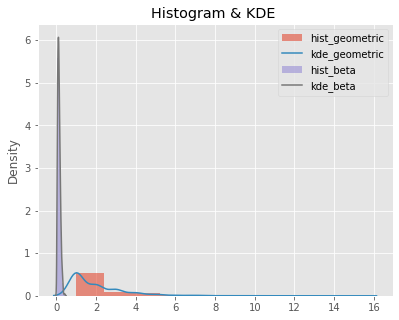

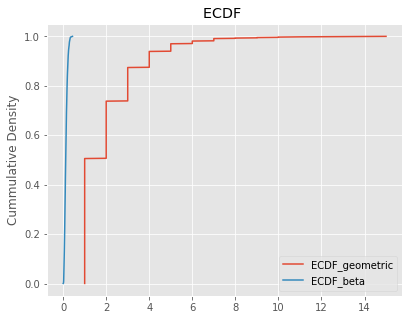

In [23]:
np.random.seed(SEED)
dist_sample1 = np.random.geometric(0.5, sample_size)
np.random.seed(SEED)
dist_sample2 = np.random.beta(3, 20, sample_size)
show_2_sample_comparisons(dist_sample1, dist_sample2, samples_labels=['geometric','beta'], show_ecdfs=True)

#### Experiment 6 - Multiple samples from same generator

This experiment shows the comparison of 2 samples from the exact same generator(Normal distribution) sampled multiple times.

In [24]:
def run_multiple_samples_experiment(sample_size, num_of_samples):
    np.random.seed(SEED)
    rg_scores = list()
    ks_pvalues = list()
    cvm_pvalues = list()
    for _ in range(num_of_samples):
        dist_sample1 = np.random.normal(0, 1, sample_size)
        dist_sample2 = np.random.normal(0, 1, sample_size)
        rg_score, ks_pvalue, cvm_pvalue = get_empirical_comparison(dist_sample1, dist_sample2)
        rg_percent_similarity = (1 - rg_score) * 100
        rg_scores.append(rg_percent_similarity)
        ks_pvalues.append(ks_pvalue)
        cvm_pvalues.append(cvm_pvalue)

    log_multi_test_statistics(rg_scores, ks_pvalues, cvm_pvalues, scores_units=['[%]']*4)

##### Small sample size

              Results statistics              
+-------------------+------------------------+
| Statistics Metric |          Value         |
+===================+========================+
| rg_scores_mean    | 87.71579536861357 [%]  |
+-------------------+------------------------+
| rg_scores_std     | 3.9490460942957895 [%] |
+-------------------+------------------------+
| rg_scores_min     | 82.05257959815316 [%]  |
+-------------------+------------------------+
| rg_scores_max     | 96.16723962971201 [%]  |
+-------------------+------------------------+
| ks_pvalues_mean   | 0.6597920131905524     |
+-------------------+------------------------+
| ks_pvalues_std    | 0.2823077368206714     |
+-------------------+------------------------+
| ks_pvalues_min    | 0.17858668181221732    |
+-------------------+------------------------+
| ks_pvalues_max    | 0.9667464356809096     |
+-------------------+------------------------+
| cvm_pvalues_mean  | 0.5749026098220973     |
+------------

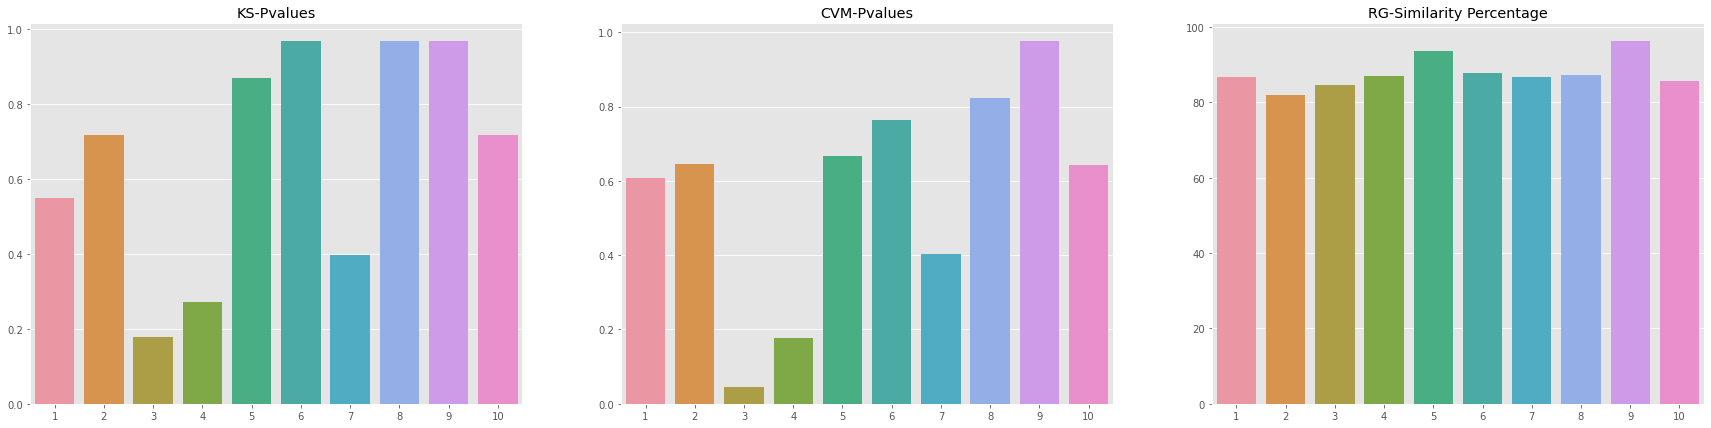

In [25]:
sample_size = 50
num_of_samples = 10
run_multiple_samples_experiment(sample_size, num_of_samples)

##### Large sample size

              Results statistics              
+-------------------+------------------------+
| Statistics Metric |          Value         |
+===================+========================+
| rg_scores_mean    | 95.26052321900161 [%]  |
+-------------------+------------------------+
| rg_scores_std     | 1.0526375490278492 [%] |
+-------------------+------------------------+
| rg_scores_min     | 93.28192217426408 [%]  |
+-------------------+------------------------+
| rg_scores_max     | 96.7020809038306 [%]   |
+-------------------+------------------------+
| ks_pvalues_mean   | 0.542453193998466      |
+-------------------+------------------------+
| ks_pvalues_std    | 0.24938101211808494    |
+-------------------+------------------------+
| ks_pvalues_min    | 0.1082872208757189     |
+-------------------+------------------------+
| ks_pvalues_max    | 0.7946637387576738     |
+-------------------+------------------------+
| cvm_pvalues_mean  | 0.5011709296501422     |
+------------

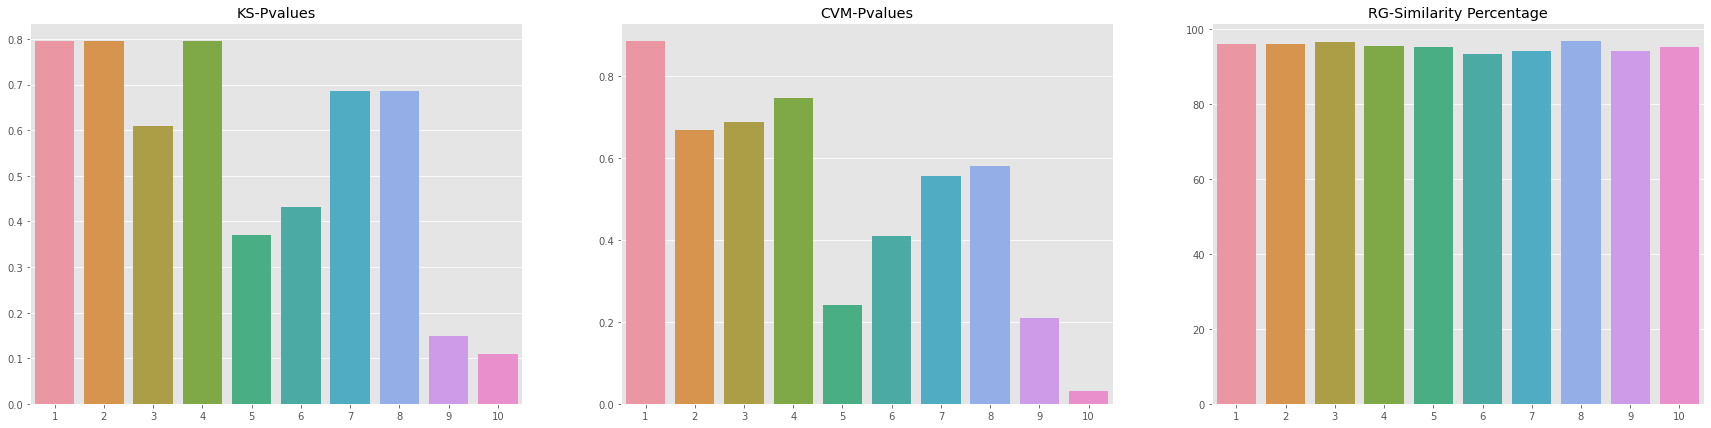

In [26]:
sample_size = 1000
num_of_samples = 10
run_multiple_samples_experiment(sample_size, num_of_samples)

#### Experiment 7 - Same generator, gradual change

This experiment shows the comparison of 2 samples from the same distribution generator(Normal distribution) function with the parameters gradually changing.

             Results statistics             
+-------------------+----------------------+
| Statistics Metric |         Value        |
+===================+======================+
| rg_scores_mean    | 1.4325693287505985   |
+-------------------+----------------------+
| rg_scores_std     | 0.24753280189208565  |
+-------------------+----------------------+
| rg_scores_min     | 1.2673321357115586   |
+-------------------+----------------------+
| rg_scores_max     | 2.1174152581303947   |
+-------------------+----------------------+
| ks_pvalues_mean   | 0.005223250248984018 |
+-------------------+----------------------+
| ks_pvalues_std    | 0.003342206586587328 |
+-------------------+----------------------+
| ks_pvalues_min    | 0.002983630440684486 |
+-------------------+----------------------+
| ks_pvalues_max    | 0.014422214291240553 |
+-------------------+----------------------+
| cvm_pvalues_mean  | 0.05332971726166047  |
+-------------------+----------------------+
| cvm_pval

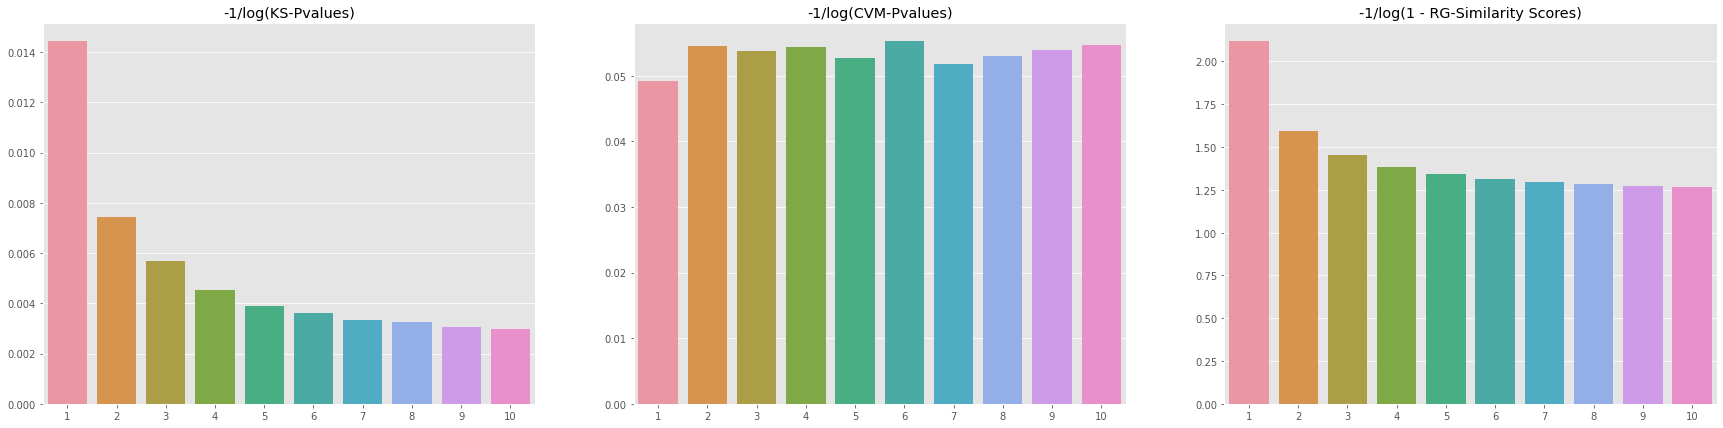

In [27]:
sample_size = 500
num_of_samples = 10
rg_scores = list()
ks_pvalues = list()
cvm_pvalues = list()
mean = 0
std = 1
mean_step = 1
std_step = 1
np.random.seed(SEED)
dist_sample1 = np.random.normal(mean, std, sample_size)
for _ in range(num_of_samples):
    np.random.seed(SEED)
    mean += mean_step
    std += std_step
    dist_sample2 = np.random.normal(mean, std, sample_size)
    rg_score, ks_pvalue, cvm_pvalue = get_empirical_comparison(dist_sample1, dist_sample2)
    rg_scores.append(-1/np.log(1-rg_score))
    ks_pvalues.append(-1/np.log(ks_pvalue))
    cvm_pvalues.append(-1/np.log(cvm_pvalue))

plot_titles = ["-1/log(KS-Pvalues)", "-1/log(CVM-Pvalues)", "-1/log(1 - RG-Similarity Scores)"]
log_multi_test_statistics(rg_scores, ks_pvalues, cvm_pvalues, plot_titles=plot_titles)

## Real world data experiments
This section of the experiments shows how real world datasets compared with our method vs Kolmogorov-Smirnov and Cramér-von Mises statistical tests.
<br>
See explanation about the experiments in the experiments functions below.

### Experiments functions

#### Single sample experiment

This function demonstrates an experiment of splitting a datasett to two groups, e.g. (train 80[%], test 20[%]), as an example of usage.

In [28]:
def run_single_sample_real_dataset_experiment(data, sample_size, scale_data=False, show_ecdfs=False):
    dist_sample = data.sample(sample_size).values
    dist_sample1 = dist_sample[0:int(0.2*sample_size)]
    dist_sample2 = dist_sample[int(0.2*sample_size):]
    show_2_sample_comparisons(dist_sample1, dist_sample2, scale_data=scale_data, show_ecdfs=show_ecdfs)

#### Two sample experiment

This function demonstrates an experiment of comparing 2 different features distributions as an example of usage.

In [29]:
def run_two_sample_real_dataset_experiment(data_1, data_2, scale_data=False, show_ecdfs=False):
    show_2_sample_comparisons(data_1.to_numpy(), data_2.to_numpy(), scale_data=scale_data, show_ecdfs=show_ecdfs)

#### Multiple samples experiment

This function demonstrates an experiment of splitting a dataset to two groups, e.g. (train80[%], test 20[%]), as an example of usage.
<br>
It runs the experiment multiple times, in order to see the results stability between different samples. As an example of usage, could be used for k-Fold Cross Validation.

In [30]:
def run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples, scale_data=False):
    np.random.seed(SEED)
    rg_scores = list()
    ks_pvalues = list()
    cvm_pvalues = list()
    for _ in range(num_of_samples):
        dist_sample = data.sample(sample_size).values
        dist_sample1 = dist_sample[0:int(0.2*sample_size)]
        dist_sample2 = dist_sample[int(0.2*sample_size):]
        rg_score, ks_pvalue, cvm_pvalue = get_empirical_comparison(dist_sample1, dist_sample2, scale_data=scale_data)
        rg_percent_similarity = (1 - rg_score) * 100
        rg_scores.append(rg_percent_similarity)
        ks_pvalues.append(ks_pvalue)
        cvm_pvalues.append(cvm_pvalue)

    log_multi_test_statistics(rg_scores, ks_pvalues, cvm_pvalues, scores_units=['[%]']*4)

### Dataset 1 - [Houses price prediction](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [31]:
dtfs[DS.HOUSES].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [32]:
sample_size = 1400
num_of_samples = 10

#### Experiment 1: Single sample - SalePrice - The property's sale price in dollars


         Comparison Scores          
+-------------+--------------------+
|    Metric   |        Value       |
+=============+====================+
| RG score    | 91.6235 [%]        |
+-------------+--------------------+
| KS P-Value  | 0.5309040152296465 |
+-------------+--------------------+
| CVM P-Value | 0.4023297636619444 |
+-------------+--------------------+


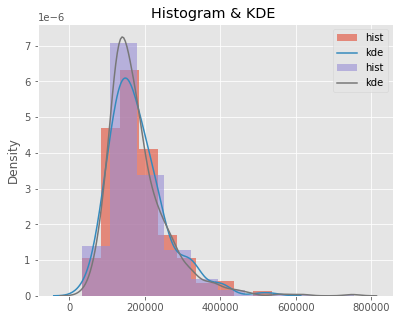

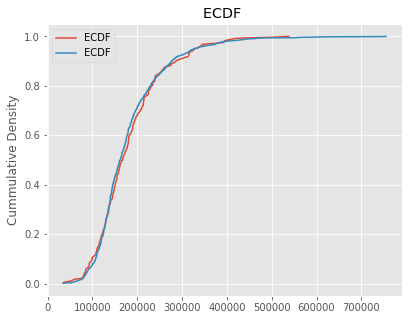

In [33]:
data = dtfs[DS.HOUSES].SalePrice
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 2: Multiple samples - SalePrice - The property's sale price in dollars


             Results statistics              
+-------------------+-----------------------+
| Statistics Metric |         Value         |
+===================+=======================+
| rg_scores_mean    | 94.28606684346308 [%] |
+-------------------+-----------------------+
| rg_scores_std     | 2.536301893316715 [%] |
+-------------------+-----------------------+
| rg_scores_min     | 88.74723988372163 [%] |
+-------------------+-----------------------+
| rg_scores_max     | 97.0819142549473 [%]  |
+-------------------+-----------------------+
| ks_pvalues_mean   | 0.3056940153292347    |
+-------------------+-----------------------+
| ks_pvalues_std    | 0.24669042553022866   |
+-------------------+-----------------------+
| ks_pvalues_min    | 0.004120300125219009  |
+-------------------+-----------------------+
| ks_pvalues_max    | 0.7092385569691008    |
+-------------------+-----------------------+
| cvm_pvalues_mean  | 0.30480503272265164   |
+-------------------+-------------

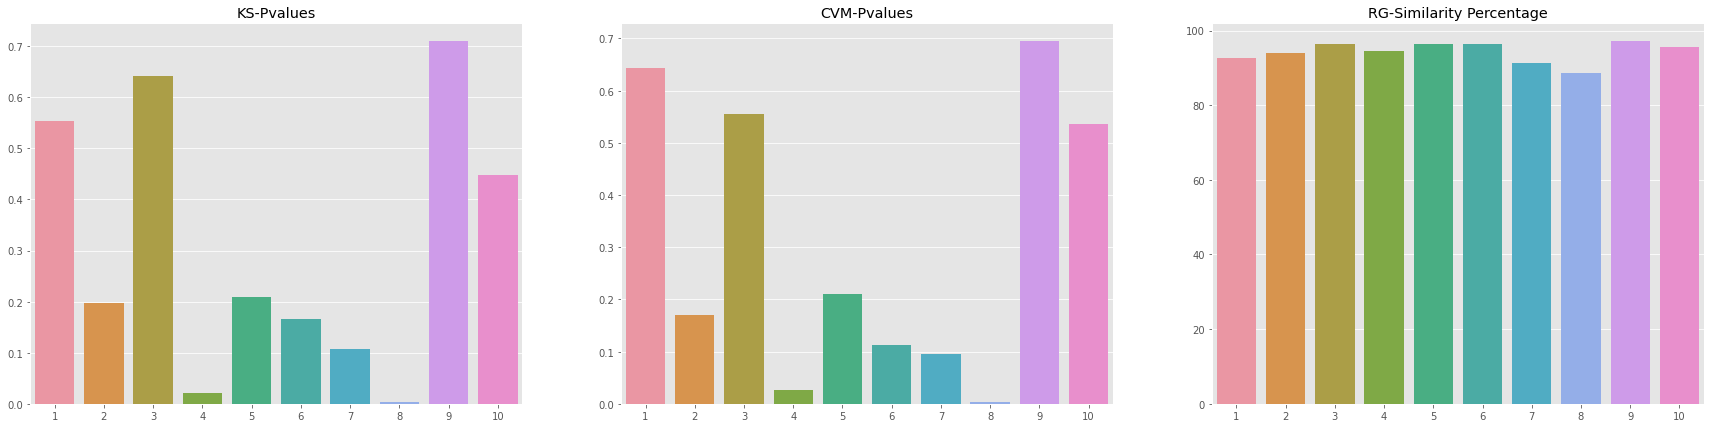

In [34]:
data = dtfs[DS.HOUSES].SalePrice
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 3: Single sample - LotArea - Lot size in square feet

          Comparison Scores          
+-------------+---------------------+
|    Metric   |        Value        |
+=============+=====================+
| RG score    | 93.3876 [%]         |
+-------------+---------------------+
| KS P-Value  | 0.4281098872455769  |
+-------------+---------------------+
| CVM P-Value | 0.19165232009162392 |
+-------------+---------------------+


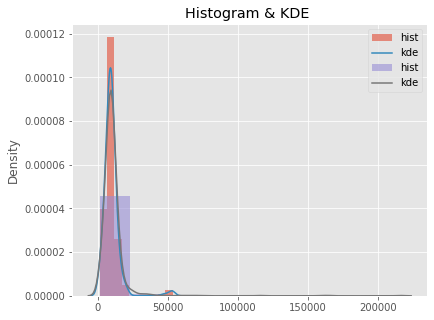

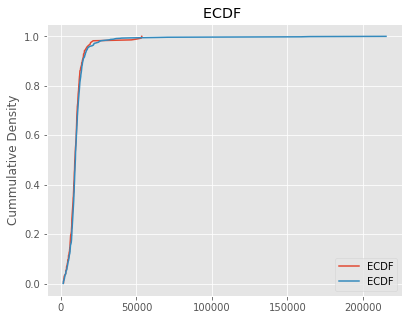

In [35]:
data = dtfs[DS.HOUSES].LotArea
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 4: Multiple samples - LotArea - Lot size in square feet

             Results statistics              
+-------------------+-----------------------+
| Statistics Metric |         Value         |
+===================+=======================+
| rg_scores_mean    | 87.5194680041582 [%]  |
+-------------------+-----------------------+
| rg_scores_std     | 7.455229004931967 [%] |
+-------------------+-----------------------+
| rg_scores_min     | 70.87392845780354 [%] |
+-------------------+-----------------------+
| rg_scores_max     | 98.66484123940285 [%] |
+-------------------+-----------------------+
| ks_pvalues_mean   | 0.5372699566628393    |
+-------------------+-----------------------+
| ks_pvalues_std    | 0.337332161713066     |
+-------------------+-----------------------+
| ks_pvalues_min    | 0.010204683055755972  |
+-------------------+-----------------------+
| ks_pvalues_max    | 0.9782674929742473    |
+-------------------+-----------------------+
| cvm_pvalues_mean  | 0.5357064335178151    |
+-------------------+-------------

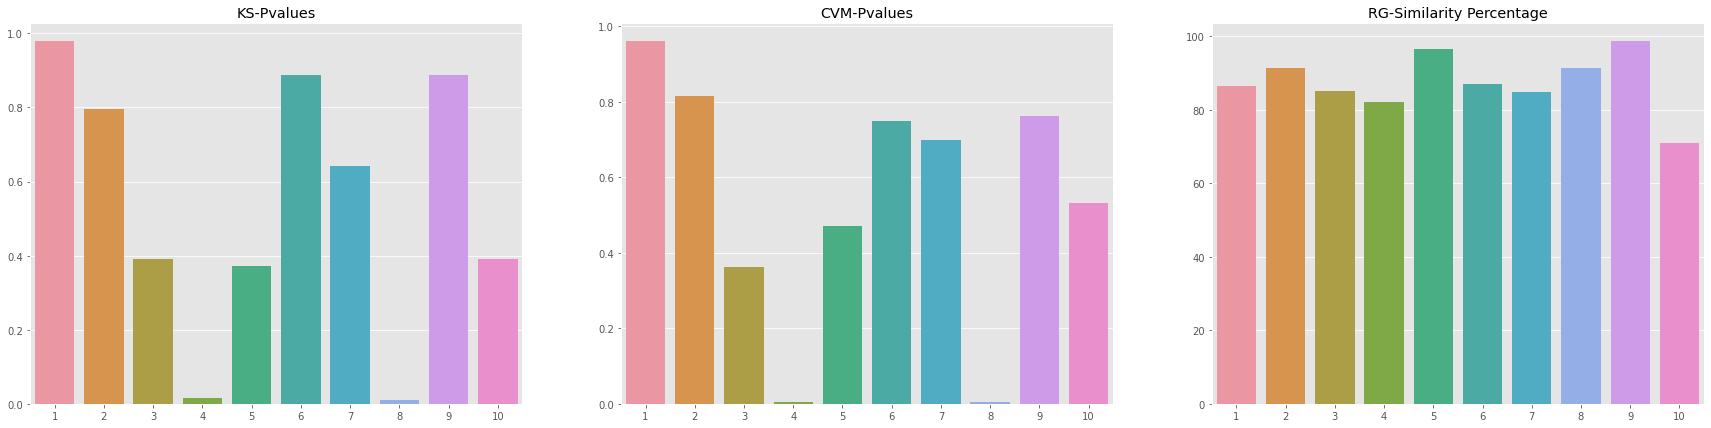

In [36]:
data = dtfs[DS.HOUSES].LotArea
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 5: Single sample - SalePrice vs LotArea comparison

This experiment shows the distribution similarity between 2 different features of the dataset with and without scaling.

          Comparison Scores           
+-------------+----------------------+
|    Metric   |         Value        |
+=============+======================+
| RG score    | 39.8629 [%]          |
+-------------+----------------------+
| KS P-Value  | 0.0                  |
+-------------+----------------------+
| CVM P-Value | 6.64769997937853e-08 |
+-------------+----------------------+
  Comparison Scores with Scaled data  
+-------------+----------------------+
|    Metric   |         Value        |
+=============+======================+
| RG score    | 40.9653 [%]          |
+-------------+----------------------+
| KS P-Value  | 0.0                  |
+-------------+----------------------+
| CVM P-Value | 6.64769997937853e-08 |
+-------------+----------------------+


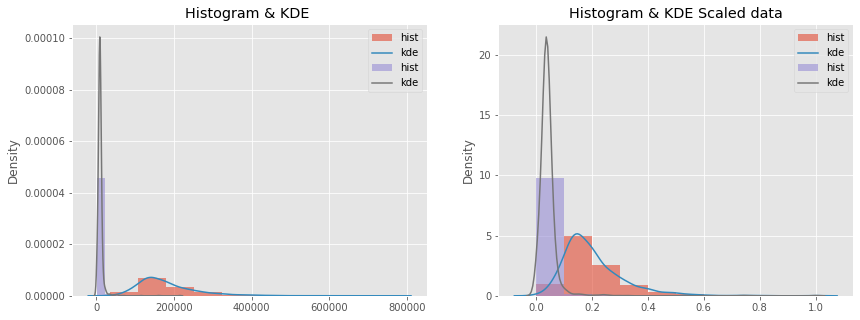

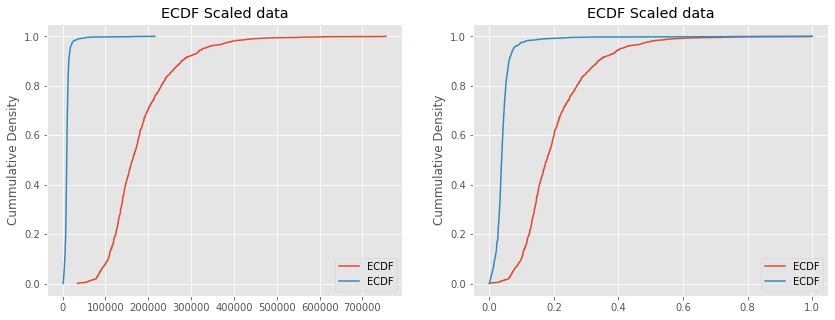

In [37]:
data_1 = dtfs[DS.HOUSES].SalePrice
data_2 = dtfs[DS.HOUSES].LotArea
run_two_sample_real_dataset_experiment(data_1, data_2, scale_data=True, show_ecdfs=True)

### Dataset 2 - [Cancer detection](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

In [38]:
dtfs[DS.CANCER].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [39]:
sample_size = 569
num_of_samples = 10

#### Experiment 1: Single sample - Radius - Mean of distances from center to points on the perimeter


         Comparison Scores          
+-------------+--------------------+
|    Metric   |        Value       |
+=============+====================+
| RG score    | 95.9095 [%]        |
+-------------+--------------------+
| KS P-Value  | 0.7779496948653234 |
+-------------+--------------------+
| CVM P-Value | 0.6991407522376867 |
+-------------+--------------------+


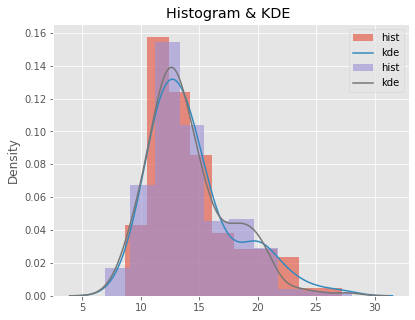

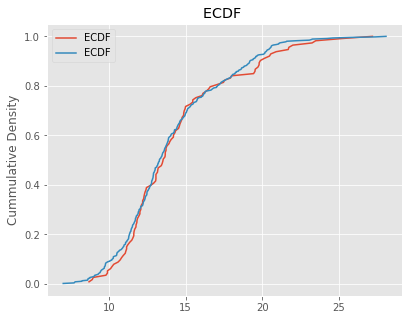

In [40]:
data = dtfs[DS.CANCER].radius_mean
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 2: Multiple samples - Radius - Mean of distances from center to points on the perimeter


              Results statistics              
+-------------------+------------------------+
| Statistics Metric |          Value         |
+===================+========================+
| rg_scores_mean    | 91.6182401756347 [%]   |
+-------------------+------------------------+
| rg_scores_std     | 3.7126113381443466 [%] |
+-------------------+------------------------+
| rg_scores_min     | 84.64612001966886 [%]  |
+-------------------+------------------------+
| rg_scores_max     | 96.98038127586621 [%]  |
+-------------------+------------------------+
| ks_pvalues_mean   | 0.46675548155890567    |
+-------------------+------------------------+
| ks_pvalues_std    | 0.28388849518682596    |
+-------------------+------------------------+
| ks_pvalues_min    | 0.012475212178668189   |
+-------------------+------------------------+
| ks_pvalues_max    | 0.973724763525873      |
+-------------------+------------------------+
| cvm_pvalues_mean  | 0.5055514899108839     |
+------------

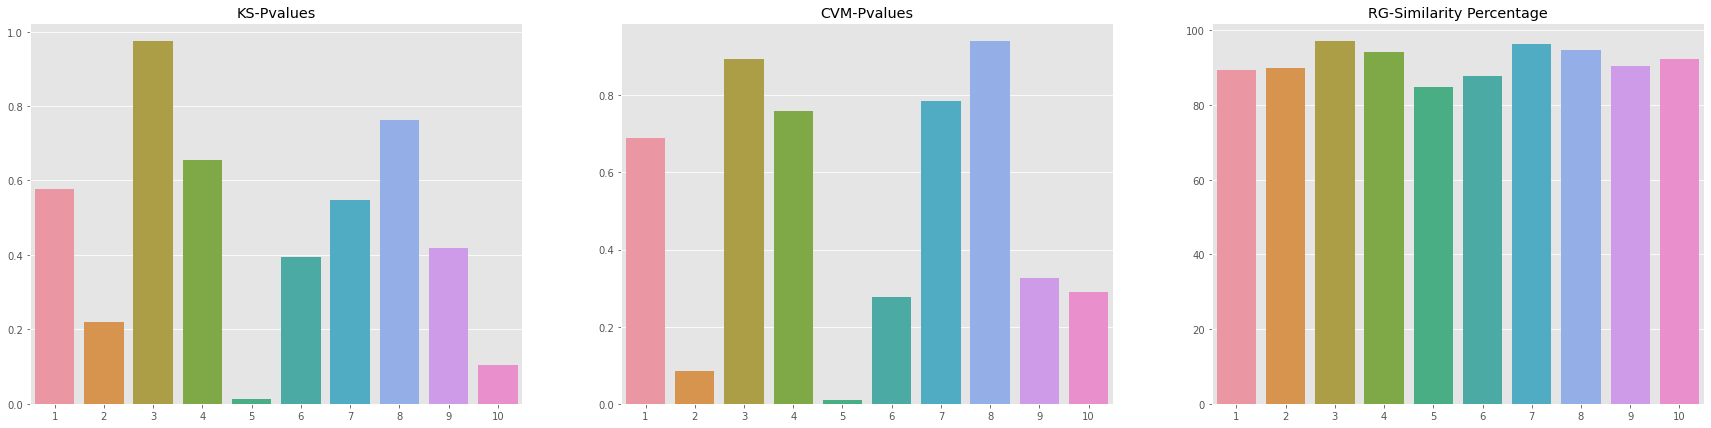

In [41]:
data = dtfs[DS.CANCER].radius_mean
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 3: Single sample - Concavity - Severity of concave portions of the contour

         Comparison Scores          
+-------------+--------------------+
|    Metric   |        Value       |
+=============+====================+
| RG score    | 93.8291 [%]        |
+-------------+--------------------+
| KS P-Value  | 0.541905651313888  |
+-------------+--------------------+
| CVM P-Value | 0.5245145380526348 |
+-------------+--------------------+


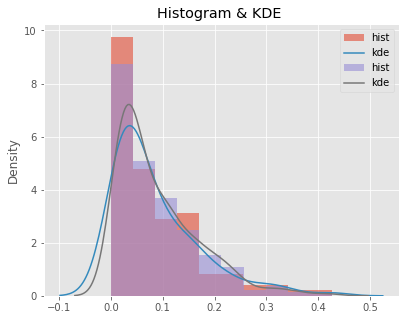

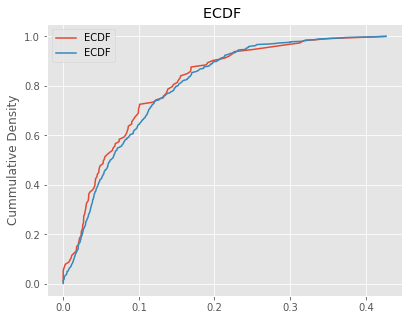

In [42]:
data = dtfs[DS.CANCER].concavity_mean
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 4: Multiple samples - Concavity - Severity of concave portions of the contour

             Results statistics              
+-------------------+-----------------------+
| Statistics Metric |         Value         |
+===================+=======================+
| rg_scores_mean    | 87.1942199145115 [%]  |
+-------------------+-----------------------+
| rg_scores_std     | 5.780163332627591 [%] |
+-------------------+-----------------------+
| rg_scores_min     | 75.42391823403345 [%] |
+-------------------+-----------------------+
| rg_scores_max     | 95.15849863356482 [%] |
+-------------------+-----------------------+
| ks_pvalues_mean   | 0.3406396553559893    |
+-------------------+-----------------------+
| ks_pvalues_std    | 0.25248187505169223   |
+-------------------+-----------------------+
| ks_pvalues_min    | 0.017999602355162292  |
+-------------------+-----------------------+
| ks_pvalues_max    | 0.7304123316305225    |
+-------------------+-----------------------+
| cvm_pvalues_mean  | 0.34140234954424525   |
+-------------------+-------------

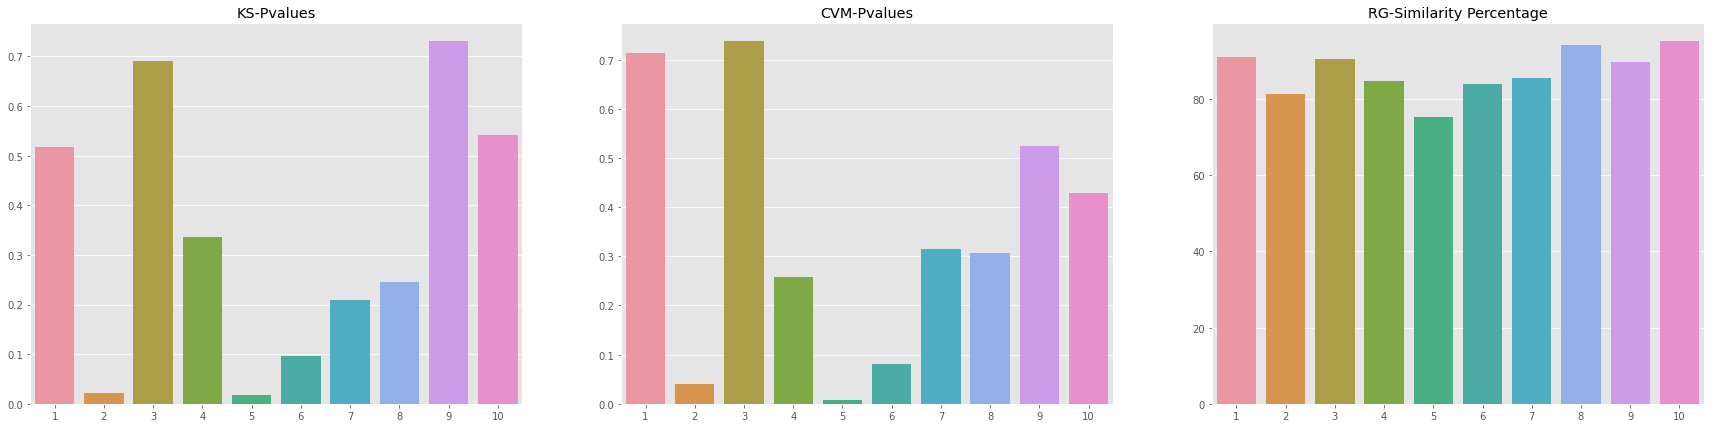

In [43]:
data = dtfs[DS.CANCER].concavity_mean
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 5: Single sample - Radius vs Concavity comparison

This experiment shows the distribution similarity between 2 different features of the dataset with and without scaling.

           Comparison Scores           
+-------------+-----------------------+
|    Metric   |         Value         |
+=============+=======================+
| RG score    | 47.9259 [%]           |
+-------------+-----------------------+
| KS P-Value  | 0.0                   |
+-------------+-----------------------+
| CVM P-Value | 3.763063249895282e-08 |
+-------------+-----------------------+
  Comparison Scores with Scaled data   
+-------------+-----------------------+
|    Metric   |         Value         |
+=============+=======================+
| RG score    | 52.2484 [%]           |
+-------------+-----------------------+
| KS P-Value  | 0.0                   |
+-------------+-----------------------+
| CVM P-Value | 3.763063249895282e-08 |
+-------------+-----------------------+


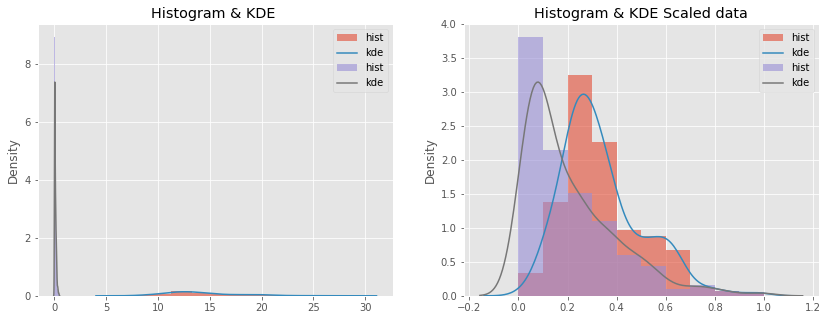

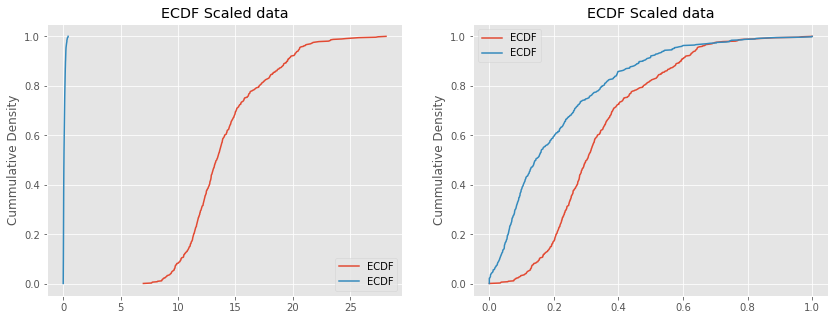

In [44]:
data_1 = dtfs[DS.CANCER].radius_mean
data_2 = dtfs[DS.CANCER].concavity_mean
run_two_sample_real_dataset_experiment(data_1, data_2, scale_data=True, show_ecdfs=True)

### Dataset 3 - [Stress detection in sleep](https://www.kaggle.com/laavanya/human-stress-detection-in-and-through-sleep)

In [45]:
dtfs[DS.SLEEPING].describe()

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
count,630.000000,630.000000,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,71.600000,21.800000,92.80000,11.700000,90.900000,88.500000,3.700000,64.500000,2.000000
std,19.372833,3.966111,3.52969,4.299629,3.902483,11.893747,3.054572,9.915277,1.415337
min,45.000000,16.000000,85.00000,4.000000,82.000000,60.000000,0.000000,50.000000,0.000000
25%,52.500000,18.500000,90.50000,8.500000,88.500000,81.250000,0.500000,56.250000,1.000000
50%,70.000000,21.000000,93.00000,11.000000,91.000000,90.000000,3.500000,62.500000,2.000000
75%,91.250000,25.000000,95.50000,15.750000,94.250000,98.750000,6.500000,72.500000,3.000000
max,100.000000,30.000000,99.00000,19.000000,97.000000,105.000000,9.000000,85.000000,4.000000


In [46]:
sample_size = 630
num_of_samples = 10

#### Experiment 1: Single sample - sr - Snoring range of the user


         Comparison Scores          
+-------------+--------------------+
|    Metric   |        Value       |
+=============+====================+
| RG score    | 80.9279 [%]        |
+-------------+--------------------+
| KS P-Value  | 0.7660581404535828 |
+-------------+--------------------+
| CVM P-Value | 0.7061634266164374 |
+-------------+--------------------+


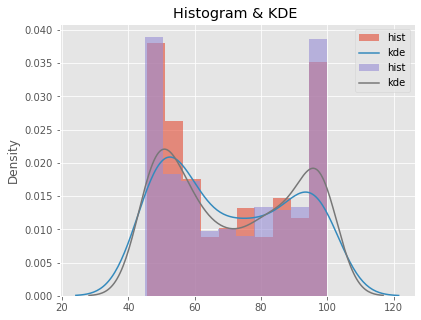

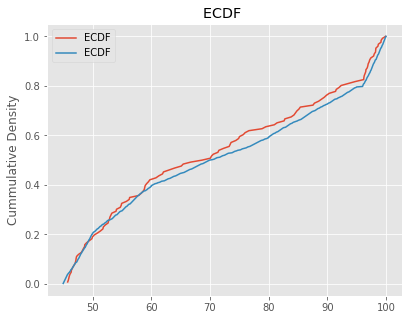

In [47]:
data = dtfs[DS.SLEEPING].sr
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 2: Multiple samples - sr - Snoring range of the user


              Results statistics              
+-------------------+------------------------+
| Statistics Metric |          Value         |
+===================+========================+
| rg_scores_mean    | 80.8623345651292 [%]   |
+-------------------+------------------------+
| rg_scores_std     | 2.8150727441431034 [%] |
+-------------------+------------------------+
| rg_scores_min     | 76.64714563388279 [%]  |
+-------------------+------------------------+
| rg_scores_max     | 85.74753576504821 [%]  |
+-------------------+------------------------+
| ks_pvalues_mean   | 0.539684223579767      |
+-------------------+------------------------+
| ks_pvalues_std    | 0.3143581151166892     |
+-------------------+------------------------+
| ks_pvalues_min    | 0.059641754938339314   |
+-------------------+------------------------+
| ks_pvalues_max    | 0.9260372436778671     |
+-------------------+------------------------+
| cvm_pvalues_mean  | 0.545548330572482      |
+------------

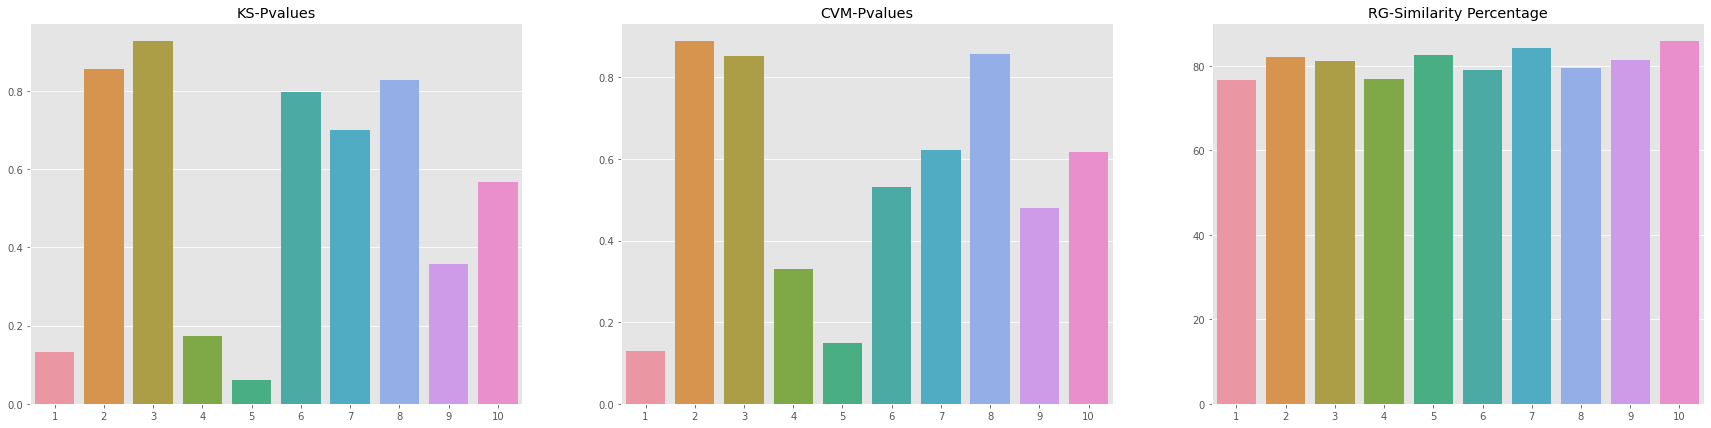

In [48]:
data = dtfs[DS.SLEEPING].sr
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 3: Single sample - t - Body temperature

          Comparison Scores          
+-------------+---------------------+
|    Metric   |        Value        |
+=============+=====================+
| RG score    | 85.9152 [%]         |
+-------------+---------------------+
| KS P-Value  | 0.20624933202720452 |
+-------------+---------------------+
| CVM P-Value | 0.14990984994420498 |
+-------------+---------------------+


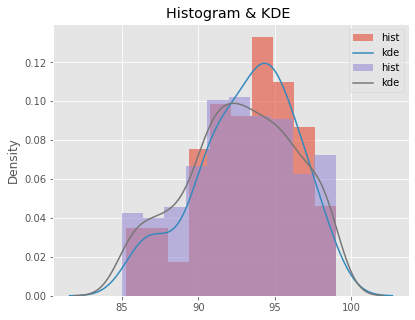

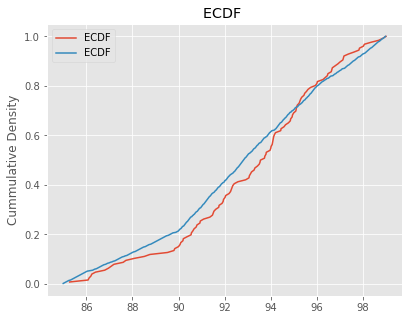

In [49]:
data = dtfs[DS.SLEEPING].t
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 4: Multiple samples - t - Body temperature

              Results statistics              
+-------------------+------------------------+
| Statistics Metric |          Value         |
+===================+========================+
| rg_scores_mean    | 87.90298526963863 [%]  |
+-------------------+------------------------+
| rg_scores_std     | 2.7023015173457092 [%] |
+-------------------+------------------------+
| rg_scores_min     | 83.74657534277831 [%]  |
+-------------------+------------------------+
| rg_scores_max     | 91.62361757399462 [%]  |
+-------------------+------------------------+
| ks_pvalues_mean   | 0.4795001528163942     |
+-------------------+------------------------+
| ks_pvalues_std    | 0.30042928087457277    |
+-------------------+------------------------+
| ks_pvalues_min    | 0.10941337249362984    |
+-------------------+------------------------+
| ks_pvalues_max    | 0.9594056665328042     |
+-------------------+------------------------+
| cvm_pvalues_mean  | 0.4886550740222284     |
+------------

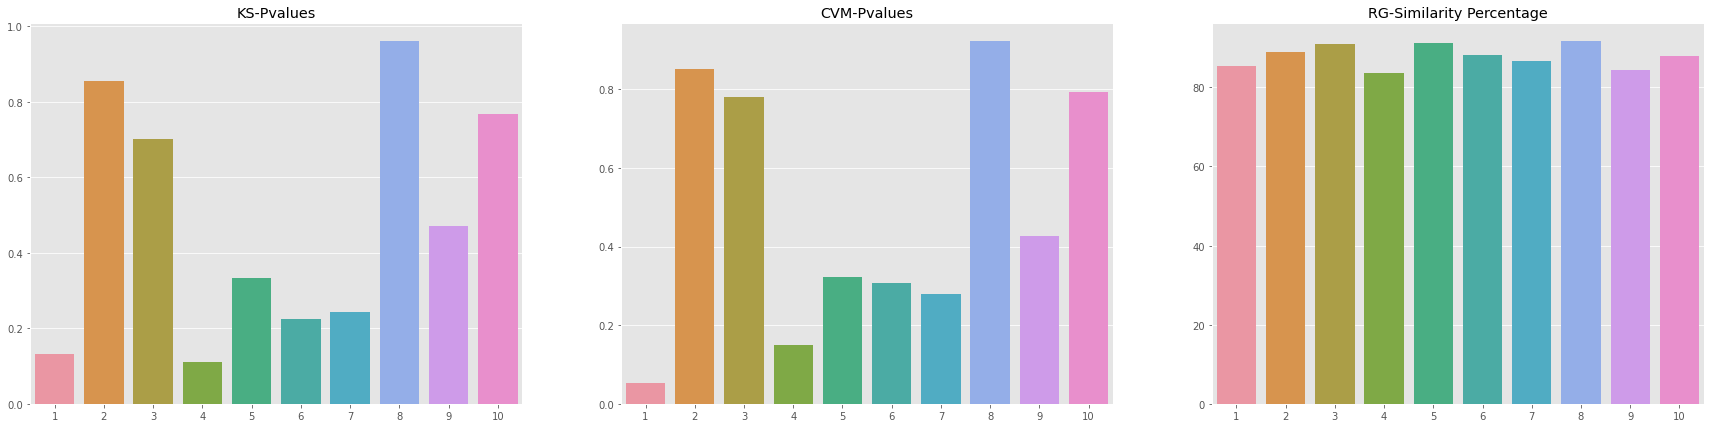

In [50]:
data = dtfs[DS.SLEEPING].t
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 5: Single sample - sr vs t comparison

This experiment shows the distribution similarity between 2 different features of the dataset with and without scaling.

           Comparison Scores            
+-------------+------------------------+
|    Metric   |          Value         |
+=============+========================+
| RG score    | 49.6575 [%]            |
+-------------+------------------------+
| KS P-Value  | 4.817821752270234e-133 |
+-------------+------------------------+
| CVM P-Value | 1.621938972018455e-08  |
+-------------+------------------------+
   Comparison Scores with Scaled data   
+-------------+------------------------+
|    Metric   |          Value         |
+=============+========================+
| RG score    | 47.8876 [%]            |
+-------------+------------------------+
| KS P-Value  | 4.817821752270234e-133 |
+-------------+------------------------+
| CVM P-Value | 1.621938972018455e-08  |
+-------------+------------------------+


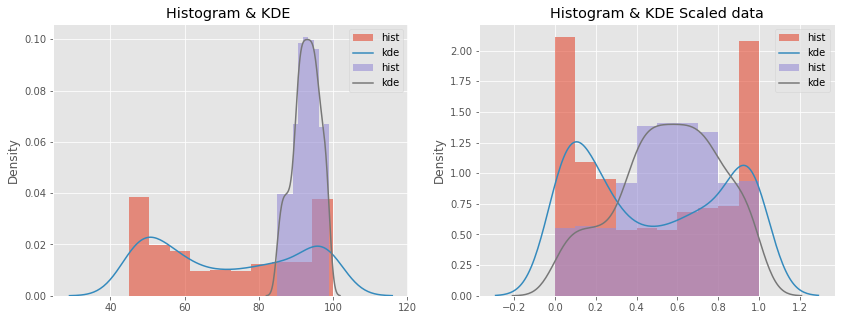

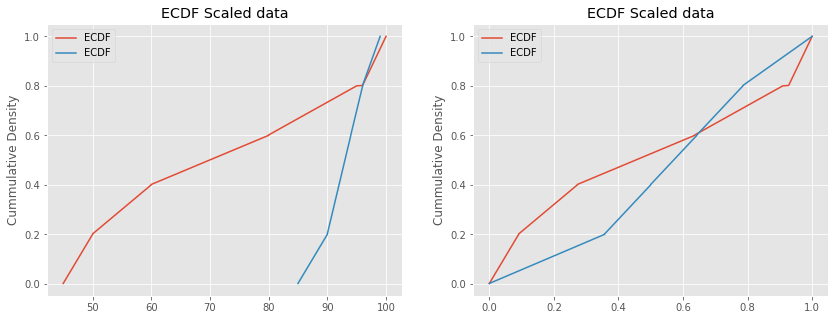

In [51]:
data_1 = dtfs[DS.SLEEPING].sr
data_2 = dtfs[DS.SLEEPING].t
run_two_sample_real_dataset_experiment(data_1, data_2, scale_data=True, show_ecdfs=True)

### Dataset 4 - [Salaries in san fransisco ](https://www.kaggle.com/kaggle/sf-salaries)

In [52]:
dtfs[DS.SALARIES].describe()

,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
count,148650.000000,148650.000000,148650.000000,148650.000000,148650.000000,148650.000000,148650.000000
mean,66055.506718,5066.037953,3630.823701,18903.084762,74752.368371,93655.453133,2004.329768
std,42885.919334,11454.389048,8006.527409,17183.943535,50533.526462,62841.639818,128.135055
min,-166.010000,-0.010000,-7058.590000,-13.800000,-618.130000,-618.130000,0.000000
25%,32798.550000,0.000000,0.000000,0.000000,36138.505000,44054.507500,2012.000000
50%,64862.310000,0.000000,800.000000,23215.625000,71422.120000,92399.120000,2013.000000
75%,94609.715000,4658.175000,4216.727500,33468.980000,105834.127500,132876.450000,2014.000000
max,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,567595.430000,2014.000000


In [53]:
sample_size = 10000
num_of_samples = 10

#### Experiment 1: Single sample - BasePay - The base pay of the salary


         Comparison Scores          
+-------------+--------------------+
|    Metric   |        Value       |
+=============+====================+
| RG score    | 94.4035 [%]        |
+-------------+--------------------+
| KS P-Value  | 0.7803919264038955 |
+-------------+--------------------+
| CVM P-Value | 0.8453824283097199 |
+-------------+--------------------+


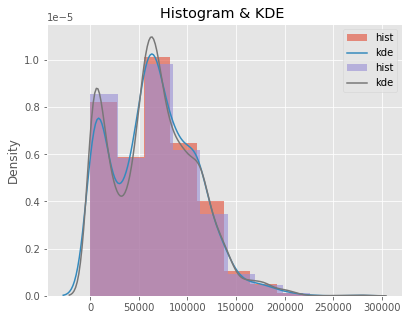

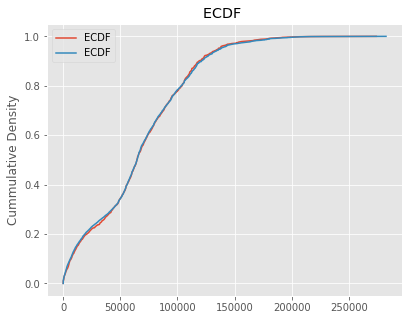

In [54]:
data = dtfs[DS.SALARIES].BasePay.sample(sample_size)
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 2: Multiple samples - BasePay - The base pay of the salary


              Results statistics              
+-------------------+------------------------+
| Statistics Metric |          Value         |
+===================+========================+
| rg_scores_mean    | 94.62198553853064 [%]  |
+-------------------+------------------------+
| rg_scores_std     | 1.0173781293765307 [%] |
+-------------------+------------------------+
| rg_scores_min     | 92.1526416459173 [%]   |
+-------------------+------------------------+
| rg_scores_max     | 95.86875566769288 [%]  |
+-------------------+------------------------+
| ks_pvalues_mean   | 0.6222931990562417     |
+-------------------+------------------------+
| ks_pvalues_std    | 0.3117384794933259     |
+-------------------+------------------------+
| ks_pvalues_min    | 0.13090856779628832    |
+-------------------+------------------------+
| ks_pvalues_max    | 0.9882002124353465     |
+-------------------+------------------------+
| cvm_pvalues_mean  | 0.6221127691170005     |
+------------

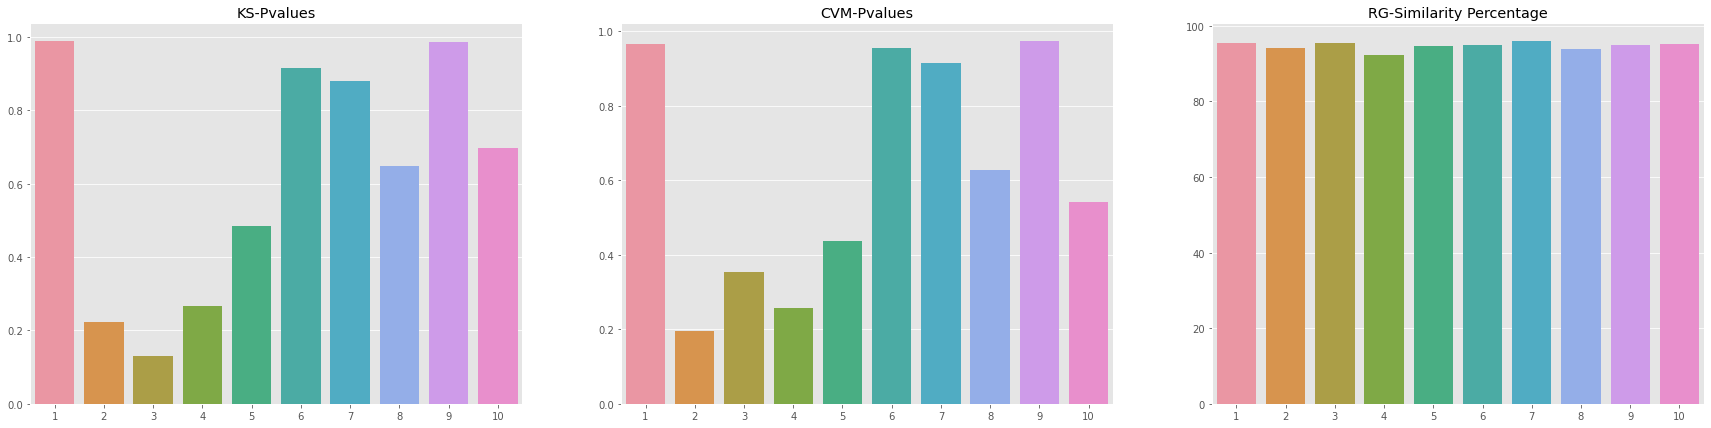

In [55]:
data = dtfs[DS.SALARIES].BasePay.sample(sample_size)
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 3: Single sample - OvertimePay - The pay for overtime hours

          Comparison Scores           
+-------------+----------------------+
|    Metric   |         Value        |
+=============+======================+
| RG score    | 92.5106 [%]          |
+-------------+----------------------+
| KS P-Value  | 0.9516910258684307   |
+-------------+----------------------+
| CVM P-Value | 8.12291081064842e-08 |
+-------------+----------------------+


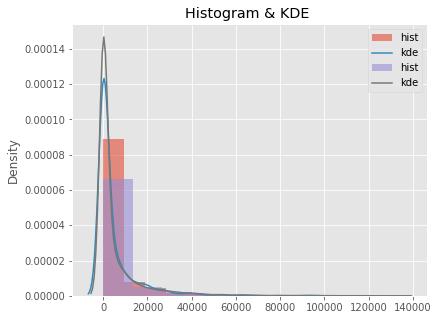

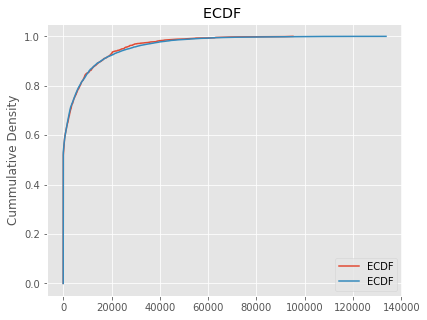

In [56]:
data = dtfs[DS.SALARIES].OvertimePay.sample(sample_size)
run_single_sample_real_dataset_experiment(data, sample_size, show_ecdfs=True)

#### Experiment 4: Multiple samples - OvertimePay - The pay for overtime hours

              Results statistics              
+-------------------+------------------------+
| Statistics Metric |          Value         |
+===================+========================+
| rg_scores_mean    | 89.86790462657129 [%]  |
+-------------------+------------------------+
| rg_scores_std     | 1.320375041351562 [%]  |
+-------------------+------------------------+
| rg_scores_min     | 86.6371323320139 [%]   |
+-------------------+------------------------+
| rg_scores_max     | 91.41468258247941 [%]  |
+-------------------+------------------------+
| ks_pvalues_mean   | 0.7122052218151924     |
+-------------------+------------------------+
| ks_pvalues_std    | 0.2757763016436771     |
+-------------------+------------------------+
| ks_pvalues_min    | 0.06050263496651364    |
+-------------------+------------------------+
| ks_pvalues_max    | 0.9999621009701785     |
+-------------------+------------------------+
| cvm_pvalues_mean  | 8.798211810212564e-08  |
+------------

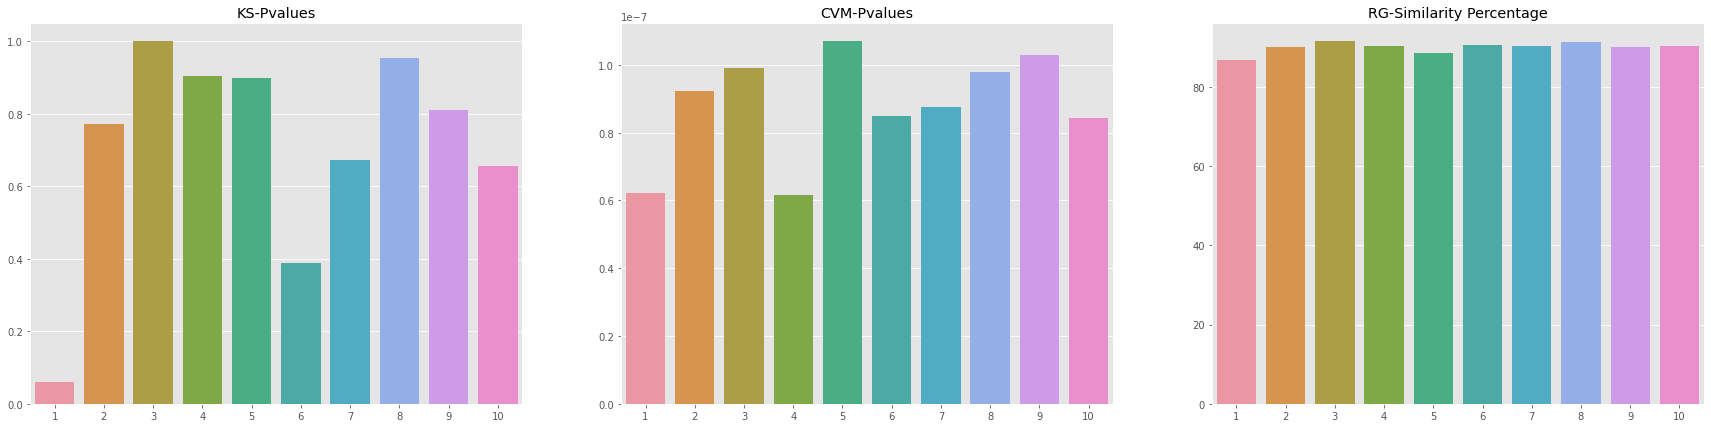

In [57]:
data = dtfs[DS.SALARIES].OvertimePay.sample(sample_size)
run_multiple_samples_real_dataset_experiment(data, sample_size, num_of_samples)

#### Experiment 5: Single sample - BasePay vs OvertimePay comparison

This experiment shows the distribution similarity between 2 different features of the dataset with and without scaling.

           Comparison Scores            
+-------------+------------------------+
|    Metric   |          Value         |
+=============+========================+
| RG score    | 66.0012 [%]            |
+-------------+------------------------+
| KS P-Value  | 0.0                    |
+-------------+------------------------+
| CVM P-Value | 2.3169184493188055e-07 |
+-------------+------------------------+
   Comparison Scores with Scaled data   
+-------------+------------------------+
|    Metric   |          Value         |
+=============+========================+
| RG score    | 65.7672 [%]            |
+-------------+------------------------+
| KS P-Value  | 0.0                    |
+-------------+------------------------+
| CVM P-Value | 2.3169184493188055e-07 |
+-------------+------------------------+


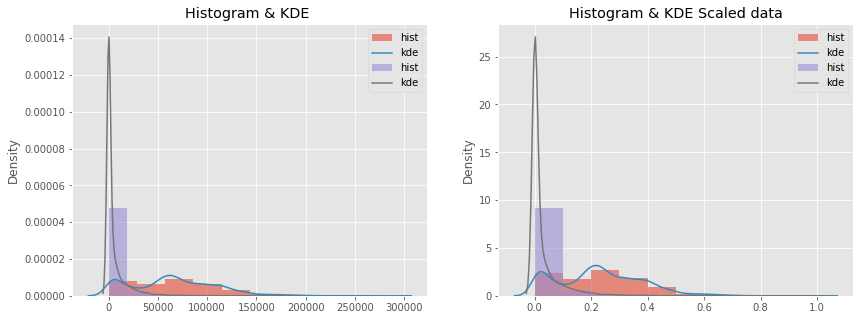

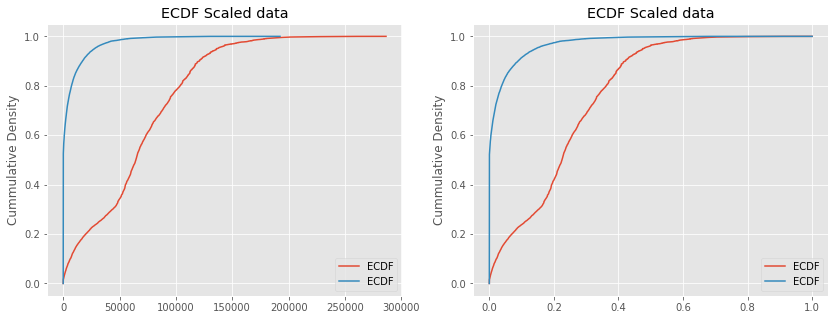

In [58]:
data_1 = dtfs[DS.SALARIES].BasePay.sample(sample_size)
data_2 = dtfs[DS.SALARIES].OvertimePay.sample(sample_size)
run_two_sample_real_dataset_experiment(data_1, data_2, scale_data=True, show_ecdfs=True)